# BCResNet 唤醒词检测演示

本notebook演示使用BCResNet网络进行唤醒词检测的完整流程：
1. 随机生成音频数据（形状为[batch_size, 1, 采样点数]）
2. 将音频转换为LogMel特征（形状为[batch_size, 1, n_mels, time_frames]）
3. 使用BCResNet模型进行预测（输出形状为[batch_size, 1]）
4. 对输出进行squeeze和sigmoid处理，得到最终预测概率（形状为[batch_size]）

1. 导入所需库

In [97]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 从项目本地模块导入必要的类
from AudioProcessor.logmel import LogMelFeatureExtractor
from WakewordModel.bcresnet import BCResNets

2. 设置运行参数

In [98]:
# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 音频参数
batch_size = 4
sample_rate = 16000  # 采样率16kHz
audio_length = 4.0   # 音频长度1秒
num_samples = int(sample_rate * audio_length)  # 16000采样点

3. 生成随机音频数据

随机音频数据形状: torch.Size([4, 1, 64000])


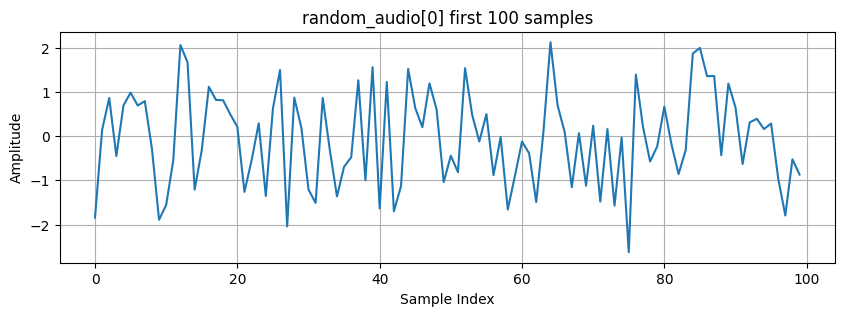

In [99]:
# 生成随机音频数据：形状为[batch_size, 1(单声道), 采样点数]
random_audio = torch.randn(batch_size, 1, num_samples).to(device)
print(f"随机音频数据形状: {random_audio.shape}")

# 可视化批次第一个音频样本的前100个采样点
plt.figure(figsize=(10, 3))
plt.plot(random_audio[0, 0, :100].cpu().numpy())  # 只显示前100个采样点
plt.title("random_audio[0] first 100 samples")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

4. 提取logmel特征并可视化

LogMel特征提取器参数: <AudioProcessor.logmel.LogMelFeatureExtractor object at 0x00000270C426FC40>
LogMel特征形状: torch.Size([4, 1, 40, 401])


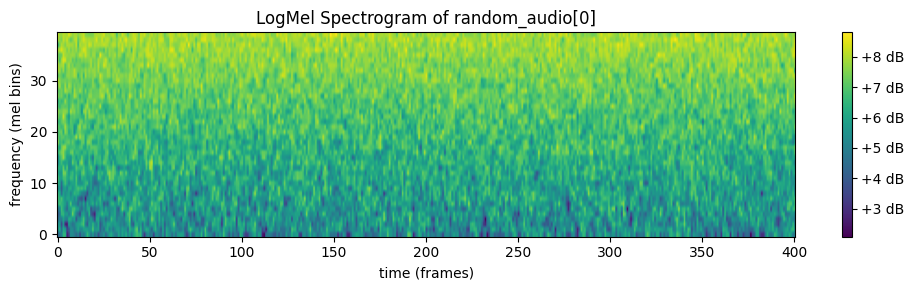

In [100]:
# 初始化特征提取器
n_mels = 40  # Mel频率数量
# 检查是能否能被8整除（在网络结构中有3次频率维度下采样）
if n_mels % 8 != 0:
    raise ValueError(f"n_mels ({n_mels}) must be divisible by 8 for the network structure.")
logmel_extractor = LogMelFeatureExtractor(device=device,
        sample_rate=16000, 
        win_length=480, 
        hop_length=160, 
        n_fft=512, 
        n_mels=n_mels # 这里的n_mels必须被spec_groups整除，spec_groups = 5
        )
print(f"LogMel特征提取器参数: {logmel_extractor}")

# 从音频中提取LogMel特征
logmel_features = logmel_extractor(random_audio)
print(f"LogMel特征形状: {logmel_features.shape}")

# 可视化第一个样本的LogMel特征
plt.figure(figsize=(10, 3))
plt.imshow(logmel_features[0, 0].cpu().numpy(), aspect='auto', origin='lower')
plt.colorbar(format='%+2.0f dB')
plt.title('LogMel Spectrogram of random_audio[0]')
plt.xlabel('time (frames)')
plt.ylabel('frequency (mel bins)')
plt.tight_layout()
plt.show()

5. 初始化bcresnet模型

In [101]:
# 初始化BCResNet模型
# 对于唤醒词检测，使用一个输出类别(num_classes=1)
model_version = 1.5  # BCResNet版本
spec_groups = 5  # 频谱组数
# 定义spec_groups前，检查是否能被n_mels整除
if n_mels % spec_groups != 0:
    raise ValueError("n_mels must be divisible by spec_groups.")
model = BCResNets(base_c=int(model_version * 8), spec_groups=spec_groups, num_classes=1).to(device)
model.eval()  # 设置为评估模式

print("模型初始化完成！")

模型初始化完成！


在唤醒词检测任务中，将num_classes设置为1而不是2（存在/不存在）有以下几个关键原因：

1. 计算效率更高
   - 输出层参数更少（最后一层卷积nn.Conv2d(self.c[-1], self.num_classes, 1)）
   - 在资源受限设备上运行更高效，减少内存占用
   
2. 二分类的自然表达
   - 使用sigmoid函数将单一输出映射到0-1之间，直接表示"唤醒词存在的概率"
   - 输出1个数值比输出2个互补概率更简洁

3. 简化决策阈值调整
   - 可以灵活调整判定阈值（不固定在0.5）
   - 便于根据不同场景平衡误唤醒率和唤醒敏感度

对比softmax方式(num_classes=2),如果使用num_classes=2，则需要：
1. 输出两个互补的类别分数
2. 使用softmax函数计算概率
3. 通常取第二个元素作为"存在"概率
4. 计算冗余（两个值总和为1）

对于这种简单的二分类任务，使用单输出+sigmoid是更高效的设计选择。

6. 进行预测并可视化

In [102]:
# 进行推理
with torch.no_grad():
    outputs = model(logmel_features)
    
print(f"模型输出形状: {outputs.shape}")

# Squeeze输出
outputs_squeezed = outputs.squeeze()
print(f"Squeeze后的输出形状: {outputs_squeezed.shape}")

# 应用sigmoid获取预测概率
probs = torch.sigmoid(outputs_squeezed)
print(f"Sigmoid后的输出形状: {probs.shape}")
print(f"唤醒词检测结果: {probs}")

# 应用阈值(0.5)进行分类
preds = (probs > 0.5).float()
print(f"唤醒词检测分类结果(0=未检测到，1=检测到): {preds}")

模型输出形状: torch.Size([4, 1])
Squeeze后的输出形状: torch.Size([4])
Sigmoid后的输出形状: torch.Size([4])
唤醒词检测结果: tensor([0.4739, 0.4739, 0.4739, 0.4739])
唤醒词检测分类结果(0=未检测到，1=检测到): tensor([0., 0., 0., 0.])


## 7. 结果解释

* **输入音频**: [4, 1, 16000] - 4个样本，单声道，每个16000采样点(1秒)
* **LogMel特征**: [4, 1, 40, 98] - 4个样本，1个通道，40个梅尔滤波器，98个时间帧
* **模型输出**: [4, 1] - 4个样本，每个有1个分数值(因为num_classes=1)
* **Squeeze后**: [4] - 4个样本的分数值
* **Sigmoid后**: [4] - 4个样本的概率值(0-1之间)

大于0.5的概率表示检测到唤醒词，小于0.5表示未检测到。

数据流向摘要：
原始音频 → [4, 1, 16000]
LogMel转换 → [4, 1, 40, 98]
BCResNet处理 → [4, 1]
Squeeze → [4]
Sigmoid → [4] (0-1概率值)
阈值判断 → [4] (0或1的二分类结果)